In [7]:
import numpy as np
from os import listdir
from os.path import isfile, join
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt

## Algorithms

In [2]:
# block power method (lecture 15)
def subspace_iter(A, k, num_iter=100):
    Y0 = np.random.random((A.shape[0], k))
    Y0, _ = np.linalg.qr(Y0)
    Y = Y0.copy()
    Y_old = Y0.copy()
    for i in range(num_iter):
        X = A.dot(Y)
        Y, _ = np.linalg.qr(X)
        Y_old = Y.copy()
    return Y

# algorithm 1
def GLRAM(A, R0, l, tol=1e-5, maxit=1000, t=1, NMSE_0=1, Rerr_0=1):
    NMSE = NMSE_0
    Rerr = Rerr_0
    R = R0.copy()
    while (NMSE > tol) and (Rerr > tol) and (t <= maxit):
        ML = np.sum(A @ R @ R.T @ np.transpose(A, axes=[0,2,1]), axis=0)
        L = subspace_iter(ML, l)
        MR = np.sum(np.transpose(A, axes=[0,2,1]) @ L @ L.T @ A, axis=0)
        R = subspace_iter(MR, l)
        NMSE_new = 1 - np.sum([np.linalg.norm(L.T @ a @ R)**2 for a in A]) / np.sum([np.linalg.norm(a)**2 for a in A])
        Rerr = np.abs((NMSE_new - NMSE)/NMSE)
        NMSE = NMSE_new
        t += 1
    return L, R

# algorithm 2


def RSVD(A,k,p,q):
    s = k+p
    m, n = A.shape
    Omega = np.random.randn(n,s)
    Y = A @ Omega  # - так надо по статье. Отличие от того что было в лекции в этой строчке, но из лекций алг показал себя лучше
    for i in range(q):
        Y = A.T @ Y
        Y = A @ Y
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    Ub,Sb,VbT = np.linalg.svd(B, full_matrices=False)
    
    return Q@Ub, Sb ,VbT
        

#more accurate version of algorithm 2 from paper (taken from lecture 16)
def orthogonalized_RSVD(A, k, p, q):
    m, n = A.shape
    G = np.random.randn(n, k + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    for i in range(q):
        W = A.T @ Q
        W, _ = np.linalg.qr(W)
        Q = A @ W
        Q, _ = np.linalg.qr(Q)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B,full_matrices=False)
    U = Q @ u
    return U, S, V


def get_stack(Ri, l):
    R = []
    for i in range(l):
        R.append(Ri)
    return np.array(R)


# computation of NMSE and Rerr
def compute_metrics(A, R, L, nmse):
    prev_nmse = nmse
    numerator_sum = 0
    denominator_sum = 0
    for i in range(A.shape[0]):
        numerator_sum += np.linalg.norm(L.T @ A[i] @ R, ord='fro')**2
        denominator_sum += np.linalg.norm(A[i], ord='fro')**2
    nmse = 1 - numerator_sum / denominator_sum
    Rerr = abs(nmse/prev_nmse - 1)
    return nmse, Rerr


# algorithm 3 from paper
def RGLRAM(A, R0, l, tol=1e-15, maxit=1000, ortho = True, p=0, q=5):
    nmse = 1
    Rerr = 1
    t = 1
    R = R0#get_stack(R0, A.shape[0])
    while (nmse > tol) and (Rerr > tol) and (t < maxit):
        # R = 
        GL = np.hstack(A @ R)
        if ortho:
            L, _, _ = orthogonalized_RSVD(GL, l, p, q)
        else: 
            L, _, _ = RSVD(GL, l, p, q)
        # transpose
        GR = np.hstack(np.transpose(A, axes=[0,2,1]) @ L)
        if ortho:
            R, _, _ = orthogonalized_RSVD(GR, l, p, q)
        else:
            R, _, _ = RSVD(GR, l, p, q)
        nmse, Rerr = compute_metrics(A, R, L, nmse)
        t = t + 1
    return L, R

## Testing

In [3]:
def relative_error(A, A_hat):
    return np.linalg.norm(A - A_hat, ord='fro')/np.linalg.norm(A_hat, ord='fro')

def calculate_errors(A, iteration, max_rank=100, p=0, q=5, ortho=True):
    errors_rglram = []
    errors_glram = []
    for k in range(1, max_rank+1, 20):
        R0 = np.random.random((A.shape[2],k))
        errors_rglram_local=[]
        errors_glram_local=[]
        L, R = RGLRAM(A, R0, k, maxit=iteration, p = p, q = q, ortho = ortho)
        M = [L.T @ Ai @ R for Ai  in A]
        for j in range(len(M)):
            A_hat = L @ M[j] @ R.T
            errors_rglram_local.append(relative_error(A[j], A_hat))
        L, R = GLRAM(A, R0, k, maxit=iteration)
        M = [L.T @ Ai @ R for Ai  in A]
        for j in range(len(M)):
            A_hat = L @ M[j] @ R.T
            errors_glram_local.append(relative_error(A[j], A_hat))

        errors_rglram.append(np.mean(errors_rglram_local))
        errors_glram.append(np.mean(errors_glram_local))
        #errors_rglram = np.array(errors_rglram).mean(axis = 0)
        #errors_exact = np.array(errors_exact).mean(axis = 0)
    return errors_rglram, errors_glram

In [13]:
onlyfiles = [f for f in listdir('train') if isfile(join('train', f))]
A = np.array([cv2.imread('train/'+name, cv2.IMREAD_GRAYSCALE) for name in onlyfiles[:10]])

In [14]:
l = 100 
errors_rglram_dict = {}
errors_glram_dict = {}
for iteration in [10, 30, 90]:
    errors_rglram, errors_glram = calculate_errors(A, iteration)
    errors_rglram_dict[iteration] = errors_rglram
    errors_glram_dict[iteration] = errors_glram
    print(iteration, 'done')

10 done
30 done
90 done


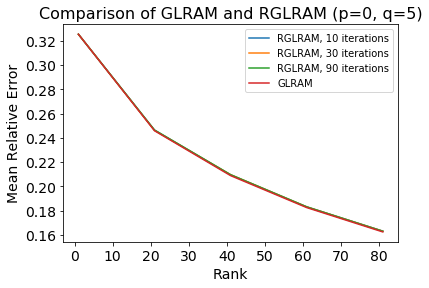

In [16]:
x = range(1, 101, 20)
plt.plot(x, errors_rglram_dict[10],  label="RGLRAM, 10 iterations")
plt.plot(x, errors_rglram_dict[30], label="RGLRAM, 30 iterations")
plt.plot(x,errors_rglram_dict[90], label="RGLRAM, 90 iterations")
plt.plot(x,errors_glram_dict[10], label="GLRAM")
plt.title('Comparison of GLRAM and RGLRAM (p=0, q=5)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Mean Relative Error", fontsize=14)
_ = plt.xlabel("Rank", fontsize=14)

In [17]:
l = 100 
errors_rglram_dict = {}
errors_glram_dict = {}
for qs in [1, 3, 5, 10]:
    errors_rglram, errors_glram = calculate_errors(A, iteration=10, q=qs)
    errors_rglram_dict[qs] = errors_rglram
    errors_glram_dict[qs] = errors_glram
    print(qs, 'done')

1 done
3 done
5 done
10 done


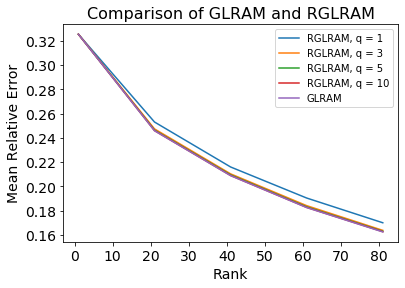

In [18]:
x = range(1, 101, 20)
plt.plot(x, errors_rglram_dict[1],  label="RGLRAM, q = 1")
plt.plot(x, errors_rglram_dict[3], label="RGLRAM, q = 3")
plt.plot(x,errors_rglram_dict[5], label="RGLRAM, q = 5")
plt.plot(x,errors_rglram_dict[10], label="RGLRAM, q = 10")
plt.plot(x,errors_glram_dict[1], label="GLRAM")
plt.title('Comparison of GLRAM and RGLRAM', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Mean Relative Error", fontsize=14)
_ = plt.xlabel("Rank", fontsize=14)

In [19]:
l = 100 
errors_rglram_dict = {}
errors_rglram_otho_dict = {}
for qs in [3, 10]:
    errors_rglram, errors_glram = calculate_errors(A, iteration=10, q=qs, ortho = True)
    errors_rglram_otho_dict[qs] = errors_rglram
    print(qs, 'done ortho')
    errors_rglram, errors_glram = calculate_errors(A, iteration=10, q=qs, ortho = False)
    errors_rglram_dict[qs] = errors_rglram
    print(qs, 'done')

3 done ortho
3 done
10 done ortho
10 done


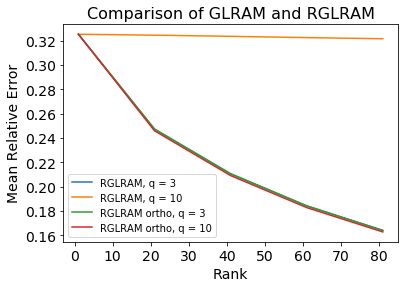

In [20]:
x = range(1, 101, 20)
plt.plot(x, errors_rglram_dict[3],  label="RGLRAM, q = 3")
plt.plot(x, errors_rglram_dict[10], label="RGLRAM, q = 10")
plt.plot(x,errors_rglram_otho_dict[3], label="RGLRAM ortho, q = 3")
plt.plot(x,errors_rglram_otho_dict[10], label="RGLRAM ortho, q = 10")
plt.title('Comparison of GLRAM and RGLRAM', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Mean Relative Error", fontsize=14)
_ = plt.xlabel("Rank", fontsize=14)

In [21]:
onlyfiles = [f for f in listdir('train') if isfile(join('train', f))]
A = np.array([cv2.imread('train/'+name, cv2.IMREAD_GRAYSCALE) for name in onlyfiles[:20]])

In [22]:


l = 100 # rank
iterations = 10
n_epochs = 3
errors_rglram_dict = {}
for number_of_A in [1, 3, 5, 10, 20]:
    errors = []
    for e in range(n_epochs):
        error = 0
        R0 = np.random.random((A.shape[2],l))
        L, R = RGLRAM(A[:number_of_A], R0, l, maxit=iterations, p=0, q=10)
        M = [L.T @ Ai @ R for Ai  in A]
        if not errors:
            for i in range(A.shape[0]):
                A_hat = L @ M[i] @ R.T
                errors.append(relative_error(A[i], A_hat))
        else:
            for i in range(A.shape[0]):
                A_hat = L @ M[i] @ R.T
                errors[i] += relative_error(A[i], A_hat)
    errors = np.array(errors) / n_epochs
    errors_rglram_dict[number_of_A] = errors
    print(number_of_A)


1
3
5
10
20


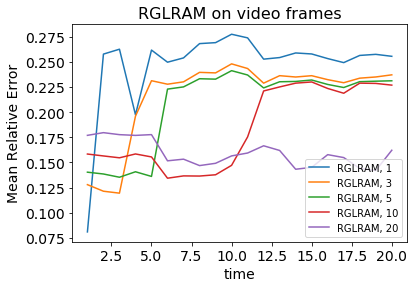

In [23]:
x = range(1, 21)
plt.plot(x,errors_rglram_dict[1],  label="RGLRAM, 1")
plt.plot(x,errors_rglram_dict[3], label="RGLRAM, 3")
plt.plot(x,errors_rglram_dict[5], label="RGLRAM, 5")
plt.plot(x,errors_rglram_dict[10], label="RGLRAM, 10")
plt.plot(x,errors_rglram_dict[20], label="RGLRAM, 20")
plt.title('RGLRAM on video frames', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Mean Relative Error", fontsize=14)
_ = plt.xlabel("time", fontsize=14)

In [24]:
l = 100 # rank
iterations = 10
n_epochs = 3
errors_rglram_dict = {}
errors_glram_dict = {}
for A_intervals in [1, 3, 5]:
    errors = []
    indices = range(0, 20, A_intervals)
    for e in range(n_epochs):
        error = 0
        R0 = np.random.random((A.shape[2],l))
        L, R = RGLRAM(A[indices], R0, l, maxit=iterations, p=0, q=10)
        M = [L.T @ Ai @ R for Ai  in A]
        if not errors:
            for i in range(A.shape[0]):
                A_hat = L @ M[i] @ R.T
                errors.append(relative_error(A[i], A_hat))
        else:
            for i in range(A.shape[0]):
                A_hat = L @ M[i] @ R.T
                errors[i] += relative_error(A[i], A_hat)
    errors = np.array(errors) / n_epochs
    errors_rglram_dict[A_intervals] = errors
    
    
    errors = []
    L, R = GLRAM(A[indices], R0, l, maxit=iterations)
    M = [L.T @ Ai @ R for Ai  in A]
    for i in range(A.shape[0]):
        A_hat = L @ M[i] @ R.T
        errors.append(relative_error(A[i], A_hat))
    errors_glram_dict[A_intervals] = errors
    
    print(A_intervals)

1
3
5


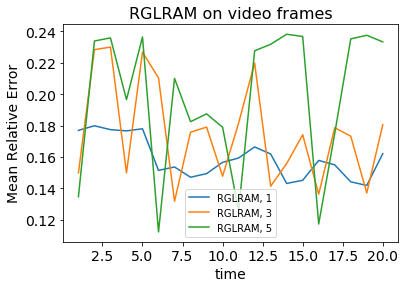

In [25]:
x = range(1, 21)
plt.plot(x,errors_rglram_dict[1],  label="RGLRAM, 1")
plt.plot(x,errors_rglram_dict[3], label="RGLRAM, 3")
plt.plot(x,errors_rglram_dict[5], label="RGLRAM, 5")
plt.title('RGLRAM on video frames', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Mean Relative Error", fontsize=14)
_ = plt.xlabel("time", fontsize=14)

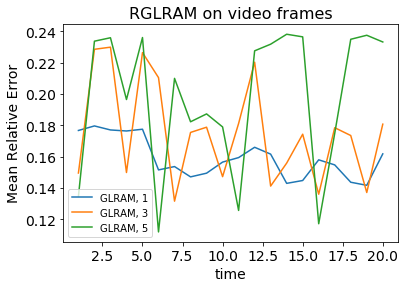

In [27]:
x = range(1, 21)
plt.plot(x,errors_glram_dict[1],  label="GLRAM, 1")
plt.plot(x,errors_glram_dict[3], label="GLRAM, 3")
plt.plot(x,errors_glram_dict[5], label="GLRAM, 5")
plt.title('RGLRAM on video frames', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Mean Relative Error", fontsize=14)
_ = plt.xlabel("time", fontsize=14)